In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,7)
from PIL import Image
from scipy import misc

import os

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Martin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#one hot encoding function
def one_hot_encoder(df_name, df_column_name):
    temp = pd.get_dummies(df_name[df_column_name]) #get dummies is used to create dummy columns
    df_name = pd.concat([df_name,temp],axis=1) #join the newly created dummy columns to original dataframe
    df_name = df_name.drop(df_column_name, axis=1) #drop the old column used to create dummy columnss
    return df_name

In [3]:
#function to draw confusion matrix
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()
    #return conf_matx

Read Train Dataset

In [4]:
train_images = pd.read_csv("fashion-mnist_train.csv")

In [5]:
train_images_x = train_images.iloc[:,1:]

In [6]:
train_images_array = train_images_x.values
train_x = train_images_array.reshape(train_images_array.shape[0], 28, 28, 1)
train_x_scaled = train_x/255

In [7]:
IMAGE_SIZE = (28, 28, 1)

Read the training labels and one hot encode the labels

In [8]:
### read the image labels and one hot encode the labels
train_images_y = train_images[['label']]

#do one hot encoding with the earlier created function
train_images_y_encoded = one_hot_encoder(train_images_y, 'label')
print(train_images_y_encoded.head())

#get the labels as an array
train_images_y_encoded = train_images_y_encoded.values

   0  1  2  3  4  5  6  7  8  9
0  0  0  1  0  0  0  0  0  0  0
1  0  0  0  0  0  0  0  0  0  1
2  0  0  0  0  0  0  1  0  0  0
3  1  0  0  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0


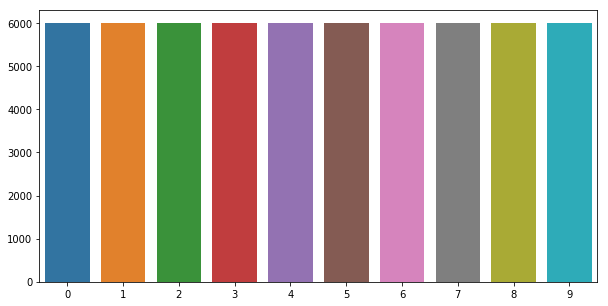

In [9]:
#check to see if distribution of target labels are equal (if not equal we need to assign weights to classes)
plt.figure(figsize=(10,5))
sns.barplot(train_images_y['label'].value_counts().index, 
        train_images_y['label'].value_counts().values)

Read the test dataset

In [12]:
test_images = pd.read_csv("fashion-mnist_test.csv")

In [13]:
test_images_x = test_images.iloc[:,1:]

test_images_array = test_images_x.values
test_x = test_images_array.reshape(test_images_array.shape[0], 28, 28, 1)
test_x_scaled = test_x/255

Read test dataset labels

In [14]:
test_images_y = test_images[['label']]
test_images_y_encoded = one_hot_encoder(test_images_y, 'label')
print(test_images_y_encoded.head())
#get the labels as an array
test_images_y_encoded = test_images_y_encoded.values

   0  1  2  3  4  5  6  7  8  9
0  1  0  0  0  0  0  0  0  0  0
1  0  1  0  0  0  0  0  0  0  0
2  0  0  1  0  0  0  0  0  0  0
3  0  0  1  0  0  0  0  0  0  0
4  0  0  0  1  0  0  0  0  0  0


Split into train and test set

In [15]:
train_x, test_x, train_y, test_y = train_test_split(train_x_scaled, 
        train_images_y_encoded, random_state = 101,test_size=0.25)

Defining the CNN Architecture

In [16]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [17]:
model = cnn_model(IMAGE_SIZE, 2)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               1505400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                7260      
__________

Define some callbacks

In [19]:
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model(IMAGE_SIZE, 2)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [20]:
n_folds=3
epochs=20
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_x, train_y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 36450 samples, validate on 4050 samples
Epoch 1/20
36450/36450 [==============================] - 394s 11ms/step - loss: 0.5595 - acc: 0.8027 - val_loss: 0.3453 - val_acc: 0.8800

Epoch 00001: val_loss improved from inf to 0.34534, saving model to fas_mnist_1.h5
Epoch 2/20
36450/36450 [==============================] - 192s 5ms/step - loss: 0.3353 - acc: 0.8788 - val_loss: 0.2878 - val_acc: 0.8943

Epoch 00002: val_loss improved from 0.34534 to 0.28777, saving model to fas_mnist_1.h5
Epoch 3/20
36450/36450 [==============================] - 99s 3ms/step - loss: 0.2723 - acc: 0.9020 - val_loss: 0.2514 - val_acc: 0.9104

Epoch 00003: val_loss improved from 0.28777 to 0.25143, saving model to fas_mnist_1.h5
Epoch 4/20
36450/36450 [==============================] - 101s 3ms/step - loss: 0.2377 - acc: 0.9122 - val_loss: 0.2521 - val_acc: 0.9069

Epoch 00004: val_loss did not improve from 0.25143
Epoch 5/20
36450/36450 [==============================] - 99s 3ms/